In [106]:
import pandas as pd
import numpy as np
import seaborn as sns
from haversine import haversine, Unit
import folium
from geopy import distance
import matplotlib.pyplot as plt

In [116]:
# Load the csv file
zillow_df = pd.read_csv('Data/zillow2.csv')
parks_df = pd.read_csv('Data/nps-parks.csv')

# Drop rows with missing values for 'sqft' column
zillow_df.dropna(subset=['Square Feet'], inplace=True)

# print(zillow_df)


In [120]:
#Data cleaning and getting rid of outliers

# print(zillow_df.dtypes)

# Outliers
zillow_df = zillow_df.drop(zillow_df[zillow_df['Address'].isin(['Canyon Plan, Juniper Trail', 'Stanton Plan, Juniper Trail', 'Cambria Plan, Juniper Trail, N Highway 24 Hwy, Hanksville, UT 84734'])].index)
zillow_df = zillow_df.drop(zillow_df[zillow_df['Price'].isin(['$536,500+','$535,500+', '$607,750+', '$588,750+', '$529,750+', '$100,000'])].index)
zillow_df = zillow_df.drop(zillow_df[zillow_df['Square Feet'].isin(['2,000 sqft','1,860 sqft', '4,000 sqft', '3,680 sqft', '2,971 sqft', '621 sqft'])].index)
zillow_df  = zillow_df.drop(zillow_df[zillow_df['Latitude'].isin(['35.5641381'])].index)
zillow_df = zillow_df.drop(zillow_df[zillow_df['Longitude'].isin(['-121.0807468'])].index)


# Need to make Price and Square Feet into floats and numbers not strings. need to strip the $ and , from price and sqft and , from square feet.
zillow_df['Price'] = zillow_df['Price'].str.replace(',','')
zillow_df['Price'] = zillow_df['Price'].str.replace('$','')
zillow_df['Price'] = zillow_df['Price'].astype(float)
# zillow_df['Square Feet'] = zillow_df['Square Feet'].str.extract('(\d+)').astype(float)
zillow_df['Square Feet'] = zillow_df['Square Feet'].str.replace(',', '').str.replace('sqft','').astype(float)

# print(zillow_df.dtypes)





C:\Users\fishe\AppData\Local\Temp\ipykernel_13972\1045656054.py:16: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  zillow_df['Price'] = zillow_df['Price'].str.replace('$','')


In [121]:
#These are parks outside of Utah. Need to drop them.
parks_df = parks_df.drop(parks_df[parks_df['name'] == 'Mormon Pioneer National Historic Trail'].index)
parks_df = parks_df.drop(parks_df[parks_df['name'] == 'California National Historic Trail'].index)
parks_df = parks_df.drop(parks_df[parks_df['name'] == 'Pony Express National Historic Trail'].index)
parks_df = parks_df.drop(parks_df[parks_df['name'] == 'Dinosaur National Monument'].index)

In [122]:
# Feature Engineering

zillow_df['price_per_sqft'] = zillow_df['Price'] / zillow_df['Square Feet']

zillow_df

,Unnamed: 0,Address,Price,Square Feet,Latitude,Longitude,price_per_sqft
0,0,"401 Silver King Dr #52, Park City, UT 84060",649000.0,452.0,40.653621,-111.510835,1435.840708
1,1,"3752 W Soft Whisper Way, Herriman, UT 84096",419000.0,1956.0,40.478933,-111.980032,214.212679
2,2,"445 N 100 W, Richfield, UT 84701",229000.0,1404.0,38.774316,-112.083100,163.105413
3,3,"754 E Logan Ave, Salt Lake City, UT 84105",650000.0,1977.0,40.734259,-111.869329,328.780981
4,4,"14506 S Ronan Ln UNIT 202, Herriman, UT 84096",355000.0,1265.0,40.487692,-111.993081,280.632411
...,...,...,...,...,...,...,...
166,166,"7457 E Stardust Ct #2.15, Heber City, UT 84032",410000.0,3704.0,40.598627,-111.293282,110.691145
167,167,"636 W Kokopelli Loop, Brian Head, UT 84719",674900.0,2250.0,37.707388,-112.859508,299.955556
168,168,"5225 N Dry Fork Canyon Rd, Vernal, UT 84078",1350000.0,4150.0,40.530220,-109.623709,325.301205
169,169,"9450 S 1400 E, Sandy, UT 84092",550000.0,1534.0,40.579482,-111.851106,358.539765


In [123]:
#Create a new cleaned data set
# Save the cleaned dataframe to a new csv file
zillow_df.to_csv('houses_cleaned.csv', index=False)

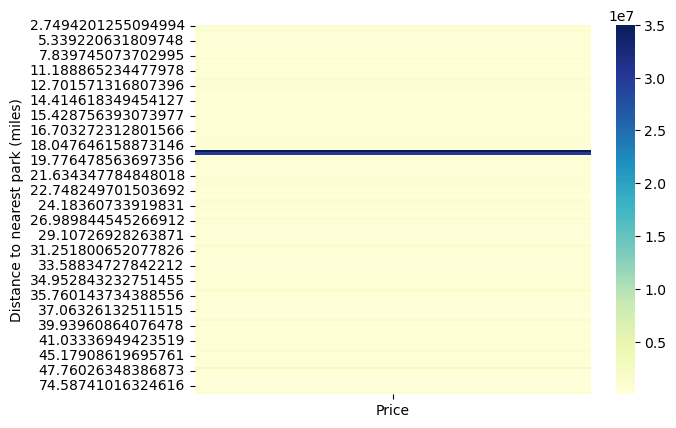

In [124]:
# Merge the two dataframes on latitude and longitude
merged_zillow_df = pd.merge(zillow_df, parks_df, on=['Latitude', 'Longitude'], how='left')

# Calculate the distance between each home and each park
distances = []
for index, row in merged_zillow_df.iterrows():
    home_loc = (row['Latitude'], row['Longitude'])
    park_locs = [(p['Latitude'], p['Longitude']) for _, p in parks_df.iterrows()]
    d = min([haversine(home_loc, p, unit=Unit.MILES) for p in park_locs])
    distances.append(d)
merged_zillow_df['Distance to nearest park (miles)'] = distances

# Group homes by distance to nearest park and calculate average price in each group
grouped_zillow_df = merged_zillow_df.groupby('Distance to nearest park (miles)').agg({'Price': 'mean'})

# Plot a heat map of average price as a function of distance to nearest park
sns.heatmap(grouped_zillow_df, cmap='YlGnBu')

# Plot a map of homes and parks
home_map = folium.Map(location=[39.5, -111.5], zoom_start=8)
for index, row in merged_zillow_df.iterrows():
    folium.Marker([row['Latitude'], row['Longitude']], popup=row['Price']).add_to(home_map)
for index, row in parks_df.iterrows():
    folium.Marker([row['Latitude'], row['Longitude']], popup=row['name'], icon=folium.Icon(color='red')).add_to(home_map)
home_map

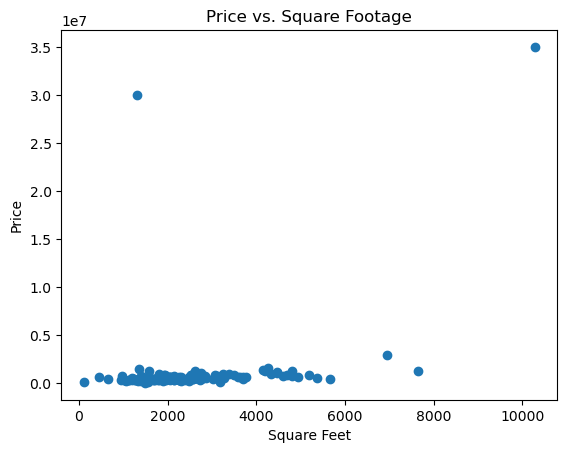

,Unnamed: 0,Address,Price,Square Feet,Latitude,Longitude,price_per_sqft
43,49,"2470 W White Pine Ln, Park City, UT 84060",35000000.0,10286.0,40.678579,-111.558335,3402.683259
147,170,"2189 W White Pine Canyon Rd, Park City, UT 84060",30000000.0,1308.0,40.676847,-111.552769,22935.779817
99,114,"3519 N Layton Ridge Dr, Layton, UT 84040",2900000.0,6955.0,41.111094,-111.904507,416.966211
34,37,"136 N 800 E, Genola, UT 84655",1595000.0,4266.0,39.999336,-111.823811,373.886545
127,147,"833 E Mountain Rd, Ogden, UT 84414",1499000.0,1350.0,41.329014,-111.954438,1110.370370
...,...,...,...,...,...,...,...
122,141,"3394 S Westcrest Rd #18, West Valley City, UT ...",120000.0,3176.0,40.698751,-111.992660,37.783375
112,128,"1031 N 500 E, Ogden, UT 84404",110000.0,1560.0,41.276220,-111.966432,70.512821
39,45,"2698 E Cedar Dr, Virgin, UT 84779",99500.0,115.0,37.404381,-112.975555,865.217391
90,104,"780 W 1125 N UNIT 50, Cedar City, UT 84721",95000.0,1500.0,37.697339,-113.074891,63.333333


In [134]:
# Load the cleaned data
cleaned_df = pd.read_csv('Data/houses_cleaned.csv')

# Plot square footage vs. price
plt.scatter(cleaned_df['Square Feet'], cleaned_df['Price'])
plt.title('Price vs. Square Footage')
plt.xlabel('Square Feet')
plt.ylabel('Price')
plt.show()

# Sort the dataframe by 'Price' column in descending order
sorted_houses = cleaned_df.sort_values('Price', ascending=False)

# Print the sorted dataframe
sorted_houses
